In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = '/content/gdrive/My Drive/Colab Notebooks/MyModel'
#import sys
#sys.path.append(root_path)
#https://github.com/huyvnphan/PyTorch-CIFAR10/blob/master/CIFAR10.ipynb

In [2]:
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.utils.data
import os
import torch.nn.functional as F
import time
import torch.distributions as td

#plots
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.ticker as ticker

#math
import numpy as np
from numpy.random import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

#modules
from cifar10_models import resnet
import data_loader
import visualize
import train_model
import FGSM
import augment
import utility

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
Size of training set: 50000
Size of validation set: 7500
Size of test set: 2500


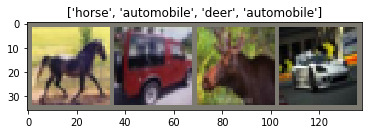

In [3]:
#LOAD DATA
batch_size=100
trainloader, validloader, testloader, attributes=data_loader.load_cifar10(batch_size, valid_ratio=.75)
N_test=attributes["N_test"]
N_train=attributes["N_train"]
N_valid = attributes["N_valid"]
classes=attributes["class_names"]
print("Size of training set: {}".format(N_train))
print("Size of validation set: {}".format(N_valid))
print("Size of test set: {}".format(N_test))
# VISUALIZE
inputs, class_data = next(iter(trainloader))
visualize.imshow(inputs[:4], title=[classes[i] for i in class_data[:4]])

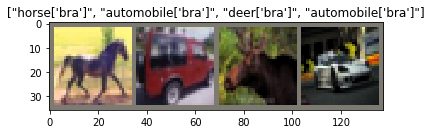

In [4]:
# TEST AUGMENTATION OF BATCH
aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs[:4], n = 1, depth = 1, augmentations="bra")
for i, _ in enumerate(aug_seqs_names):
    visualize.imshow(aug_batches[i], title=[classes[j]+str(aug_seqs_names[i]) for j in class_data[:4]])
    plt.pause(0.001)
    
# pause a bit so that plots are updated

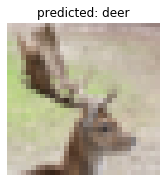

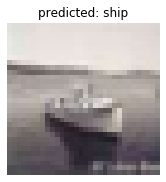

In [5]:
#load the pretrained resnet 18/34 or 50
path="cifar10_models/state_dicts/resnet18.pt"
model = resnet.resnet18(pretrained=True).to(device)
#train if necessary
#model_ft = train_model.train(model, trainloader, testloader,num_epochs=2)

model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()
visualize.visualize_model(model, testloader, classes, num_images=2)

In [6]:
#We use epsilon = 0.1, as the FID score is not high for this case (see lars kai mail, GOOD adversarial)
correct_classified_examples, miss_classified_examples, adv_examples = FGSM.getExamples(model, testloader, epsilon = 0.3, 
                                                                                       n=100000, augmentations="flr")


In [7]:
_,_,_,output_softmax_correct=FGSM.getOutput(correct_classified_examples)
_,_,_,output_softmax_miss=FGSM.getOutput(miss_classified_examples)
_,_,_,output_softmax_adv=FGSM.getOutput(adv_examples)

dkl_adv = FGSM.DKL(output_softmax_adv)
dkl_correct = FGSM.DKL(output_softmax_correct)
dkl_miss = FGSM.DKL(output_softmax_miss)

dkl_count_adv, bins_start = FGSM.DKLBin(dkl_adv, bin_size = 0.2, bin_max=10)
dkl_count_correct, bins_start = FGSM.DKLBin(dkl_correct, bin_size = 0.2, bin_max=10)
dkl_count_miss, bins_start = FGSM.DKLBin(dkl_miss, bin_size = 0.2, bin_max=10)

Text(0.5, 0, 'D_kl')

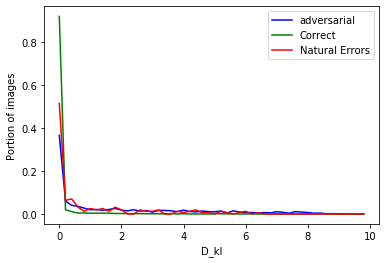

In [8]:
fig, ax = plt.subplots()
ax.plot(bins_start,dkl_count_adv,color="blue", label="adversarial")
ax.plot(bins_start,dkl_count_correct,color="green", label="Correct")
ax.plot(bins_start,dkl_count_miss, color="red", label="Natural Errors")
leg = ax.legend(loc='upper right')
ax.set_ylabel("Portion of images")
ax.set_xlabel("D_kl")

## FGSM

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 7088 / 7500 = 0.9450666666666667
20%
40%
60%
80%
100%
Epsilon: 0.1	Test Accuracy = 4024 / 7500 = 0.5365333333333333
20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3146 / 7500 = 0.41946666666666665
20%
40%
60%
80%
100%
Epsilon: 0.3	Test Accuracy = 2417 / 7500 = 0.32226666666666665
20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 7088 / 7500 = 0.9450666666666667
20%
40%
60%
80%
100%
Epsilon: 0.1	Test Accuracy = 4024 / 7500 = 0.5365333333333333
20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3146 / 7500 = 0.41946666666666665
20%
40%
60%
80%
100%
Epsilon: 0.3	Test Accuracy = 2417 / 7500 = 0.32226666666666665
20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 7088 / 7500 = 0.9450666666666667
20%
40%
60%
80%
100%
Epsilon: 0.1	Test Accuracy = 4024 / 7500 = 0.5365333333333333
20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3146 / 7500 = 0.41946666666666665
20%
40%
60%
80%
100%
Epsilon: 0.3	Test Accuracy = 2417 / 7500 = 0.32226666666666665
20%


/home/samuele/dtu/advmac/adversarial_augmentation/utility.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4), constrained_layout = True)
/home/samuele/dtu/advmac/adversarial_augmentation/utility.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4), constrained_layout = True)
/home/samuele/dtu/advmac/adversarial_augmentation/utility.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

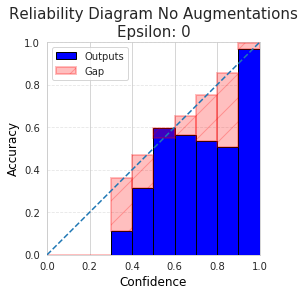

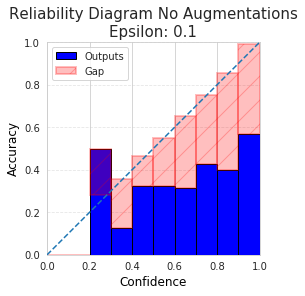

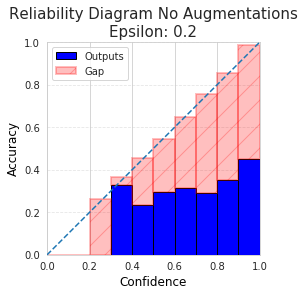

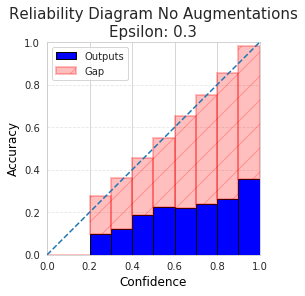

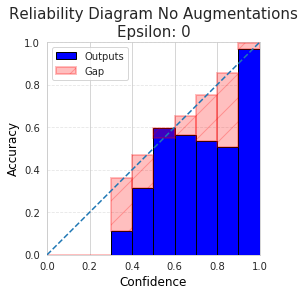

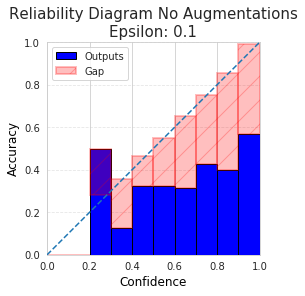

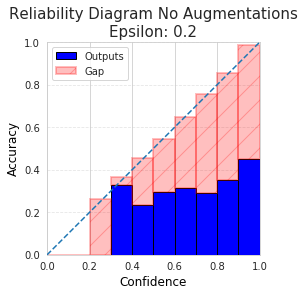

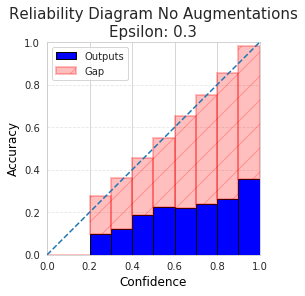

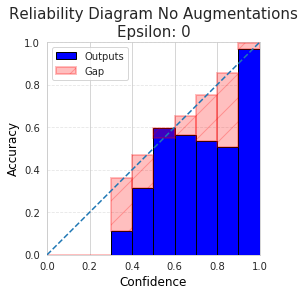

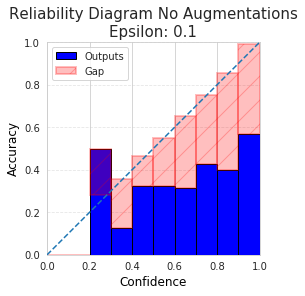

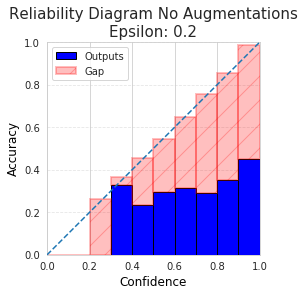

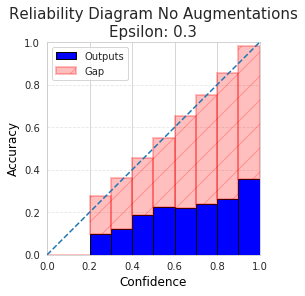

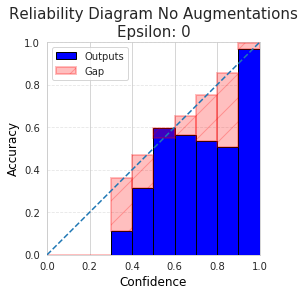

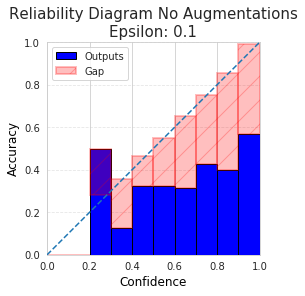

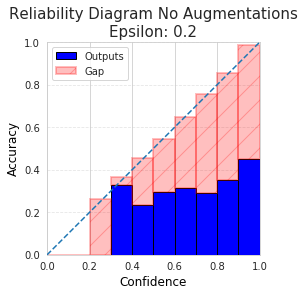

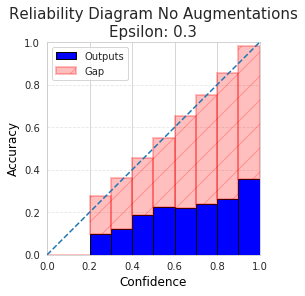

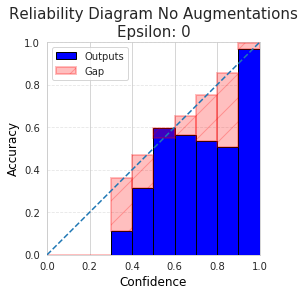

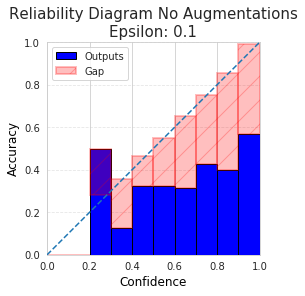

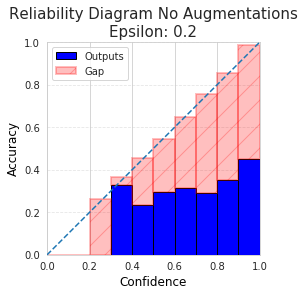

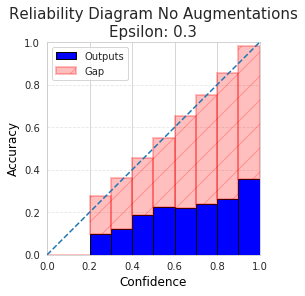

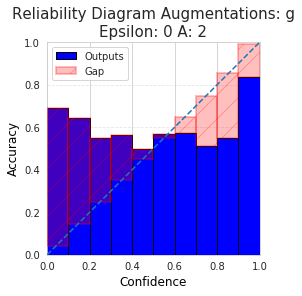

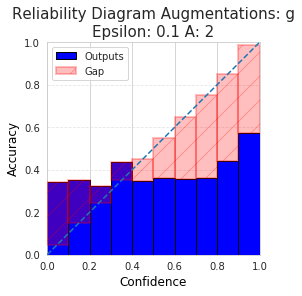

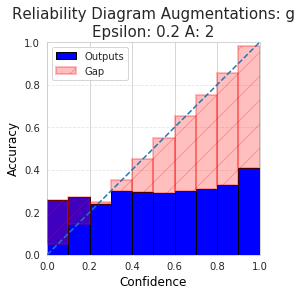

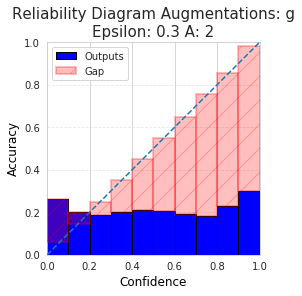

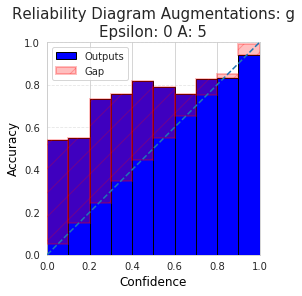

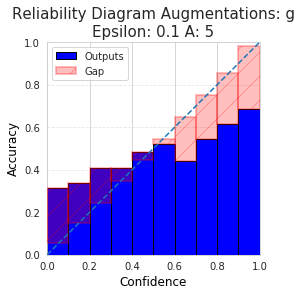

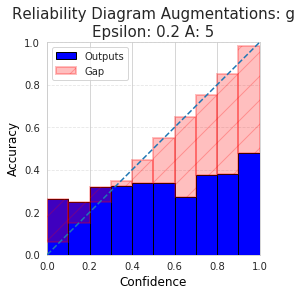

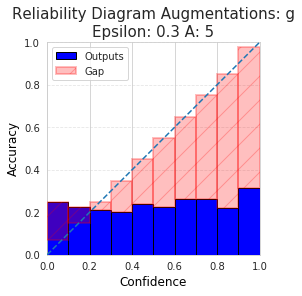

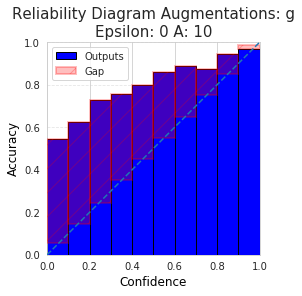

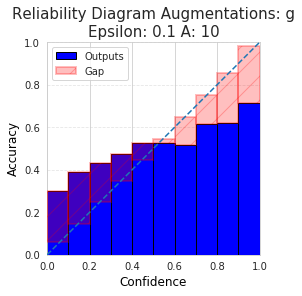

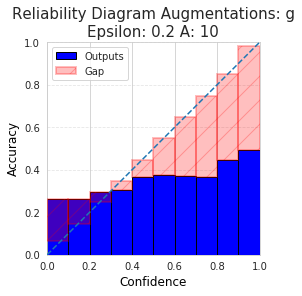

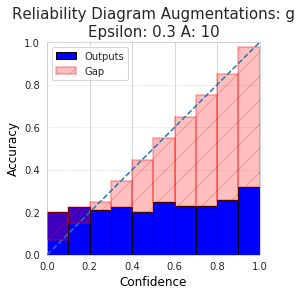

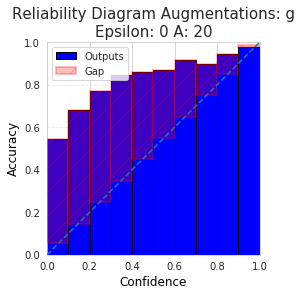

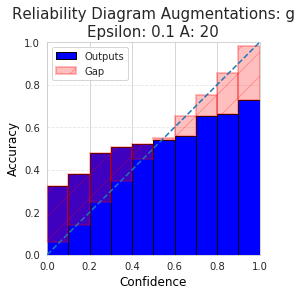

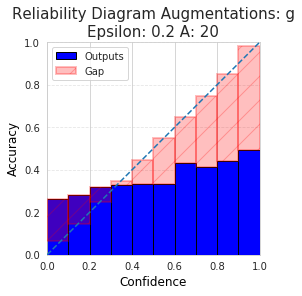

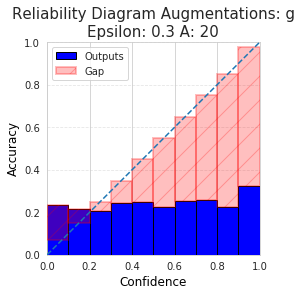

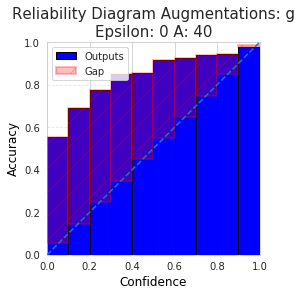

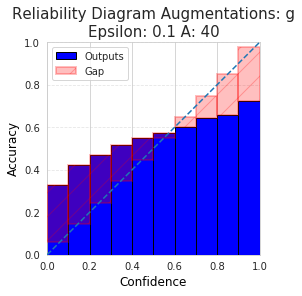

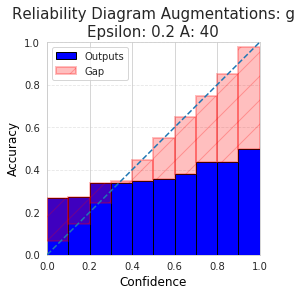

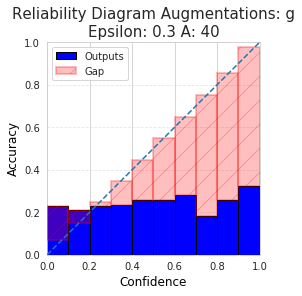

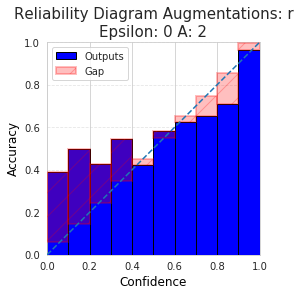

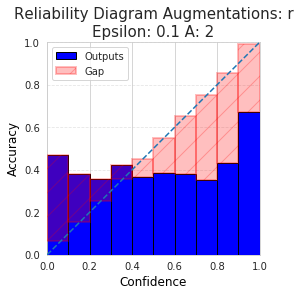

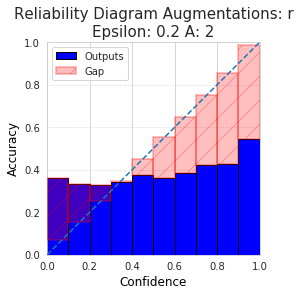

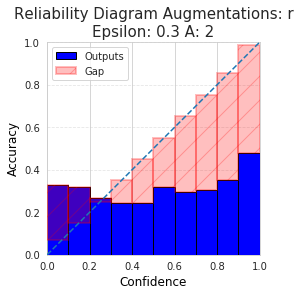

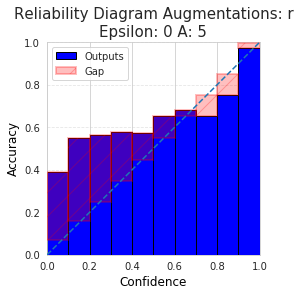

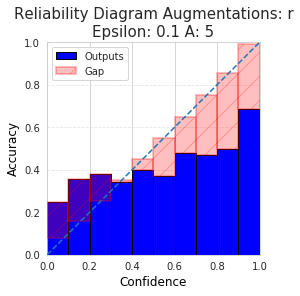

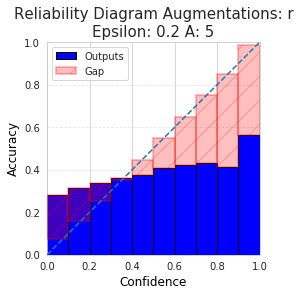

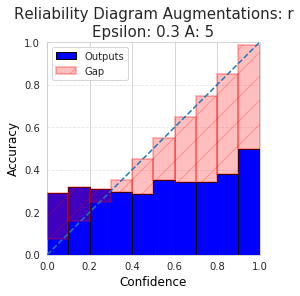

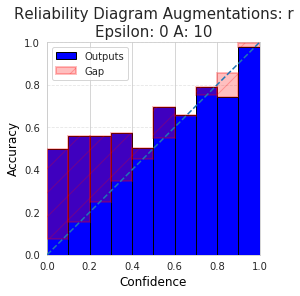

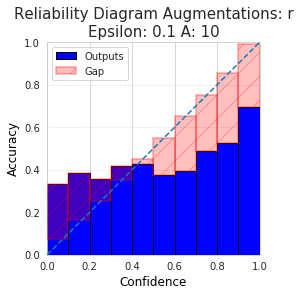

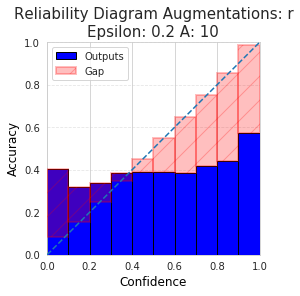

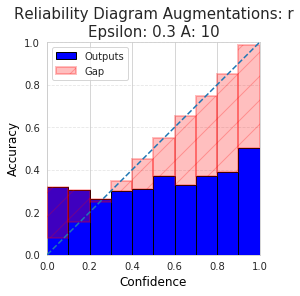

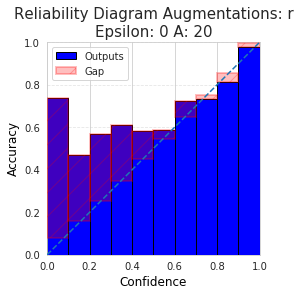

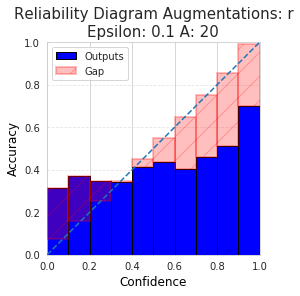

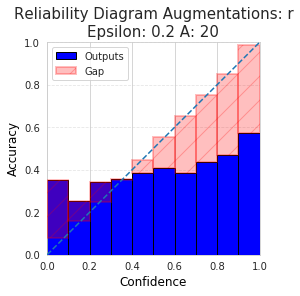

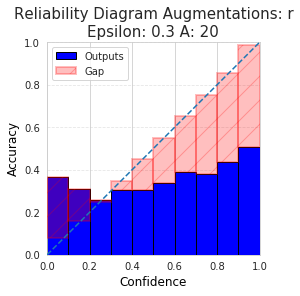

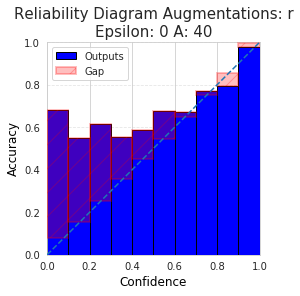

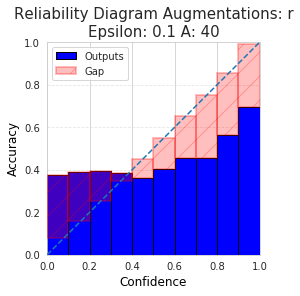

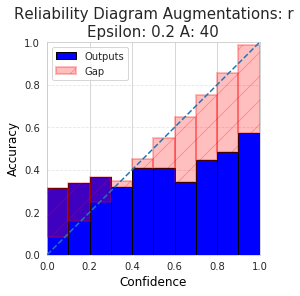

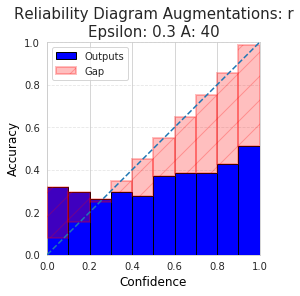

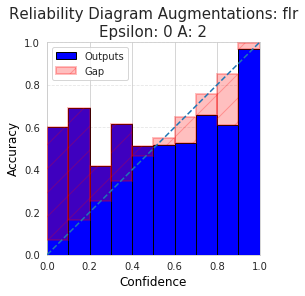

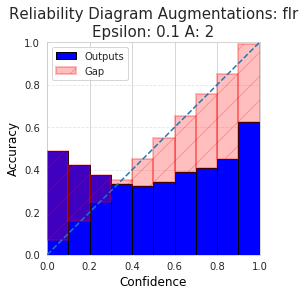

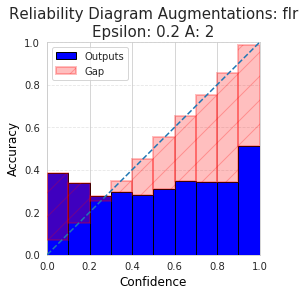

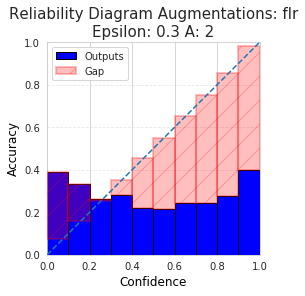

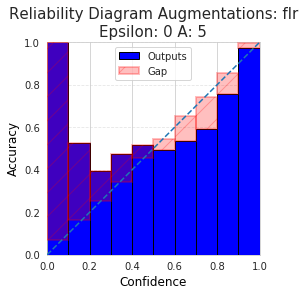

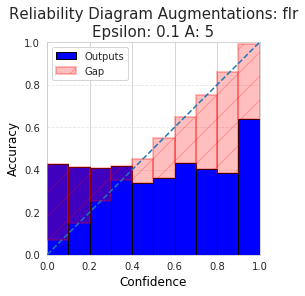

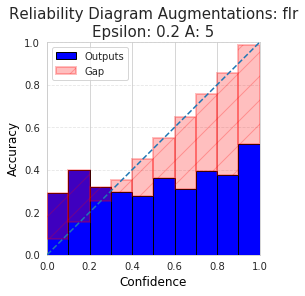

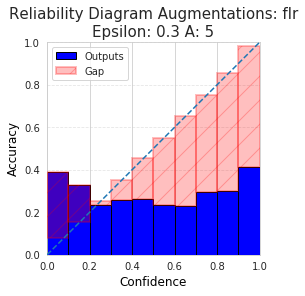

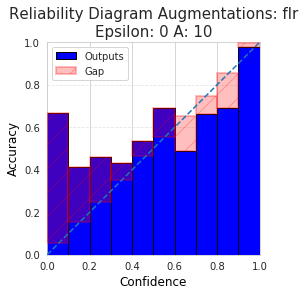

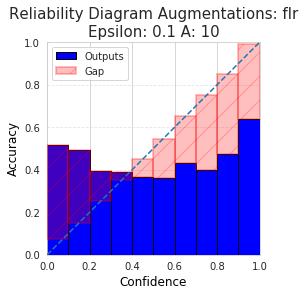

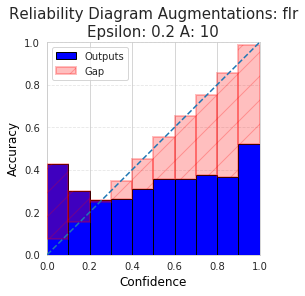

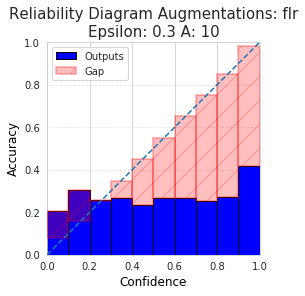

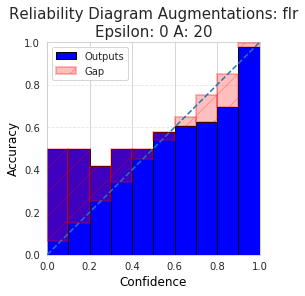

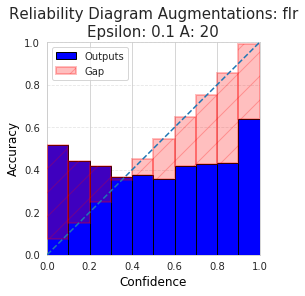

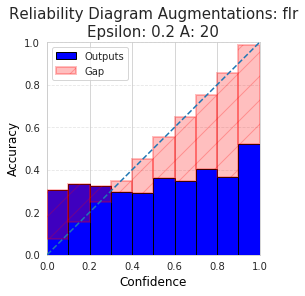

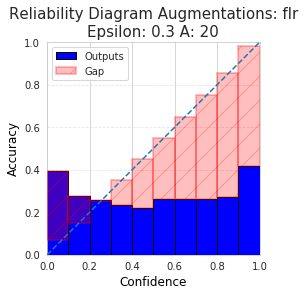

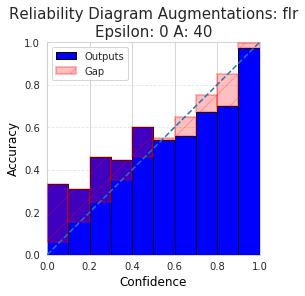

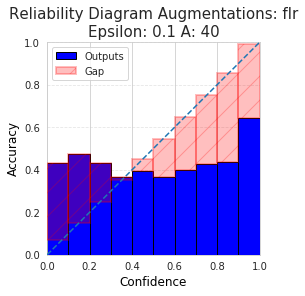

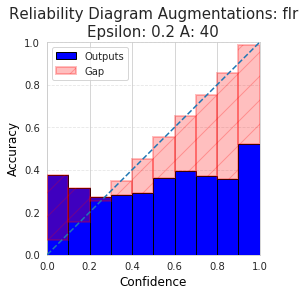

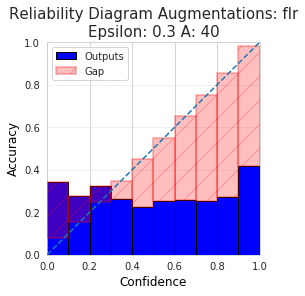

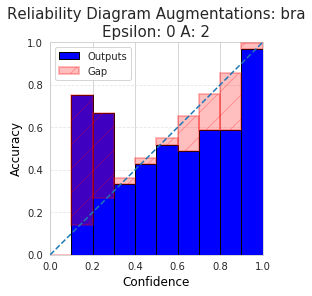

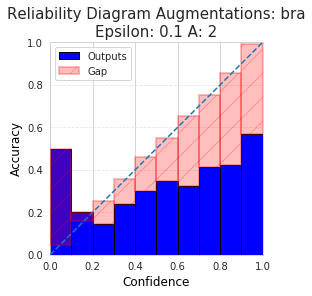

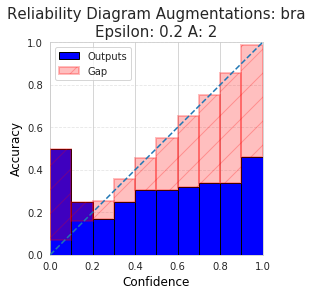

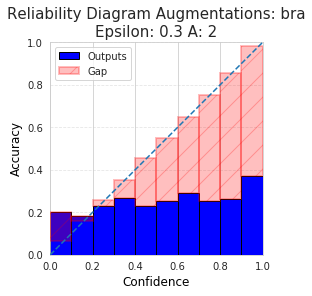

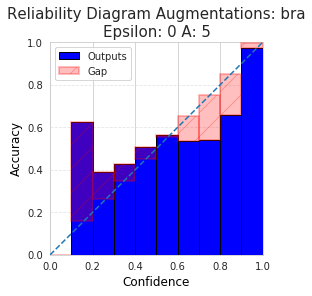

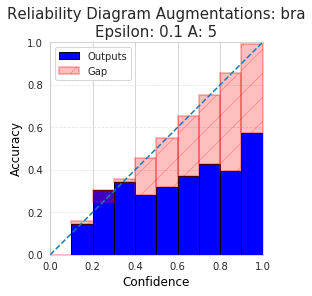

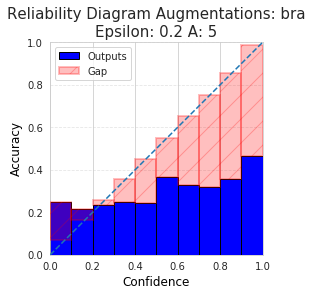

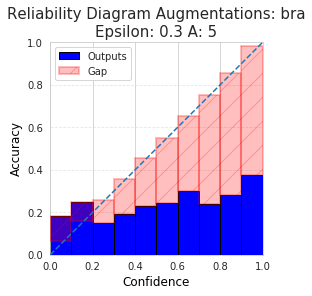

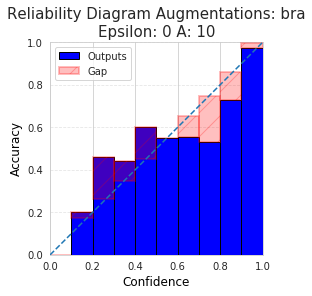

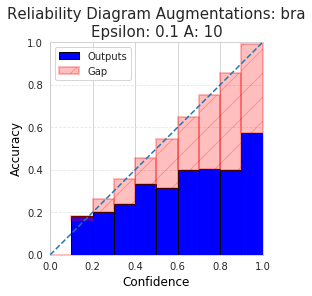

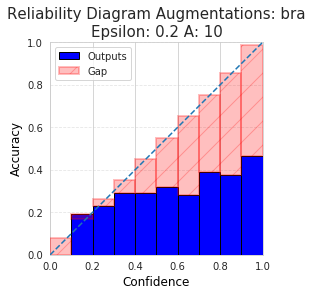

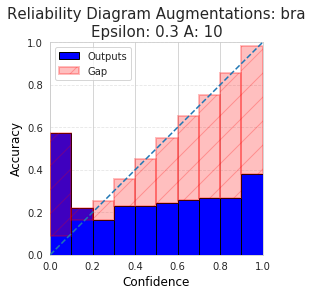

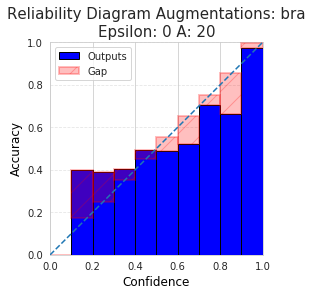

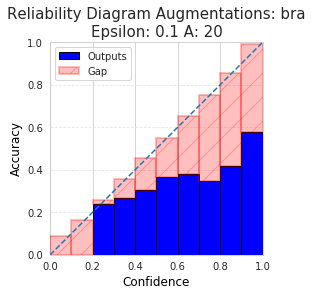

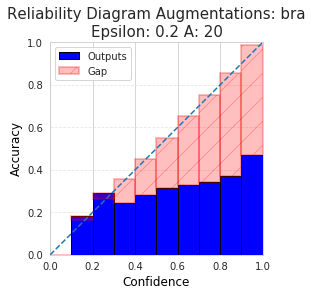

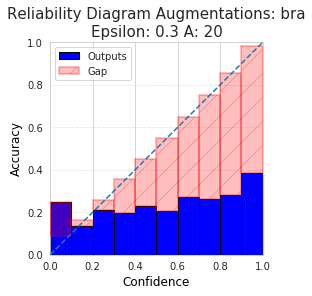

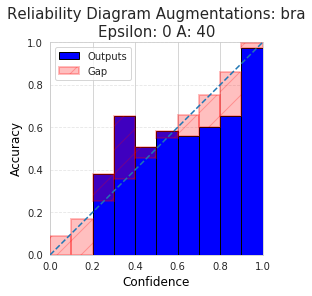

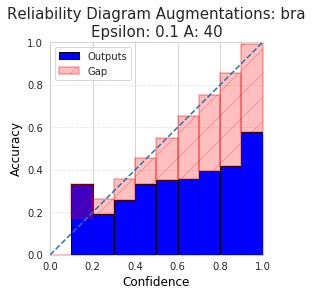

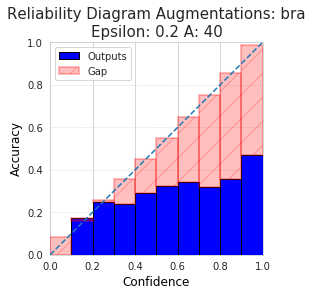

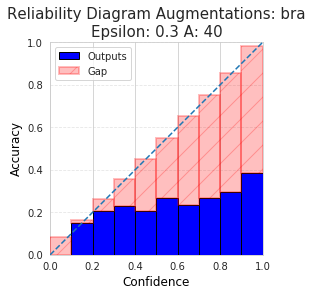

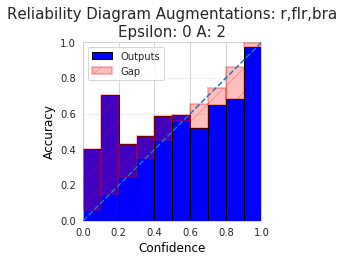

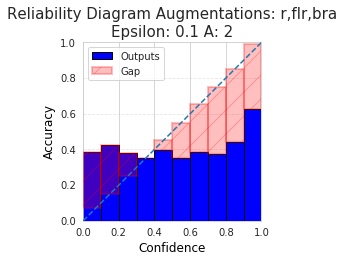

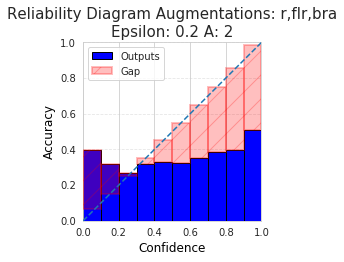

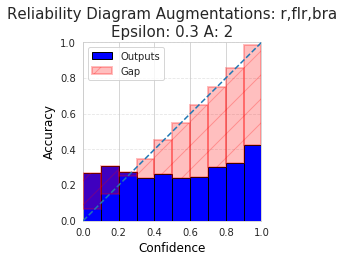

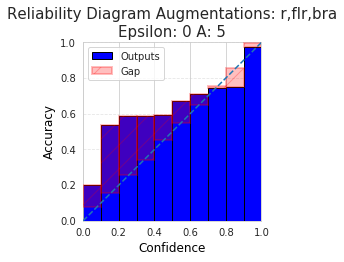

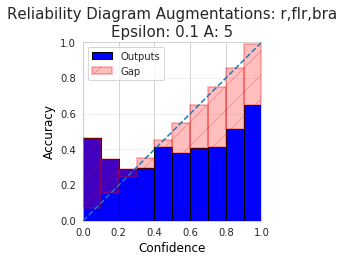

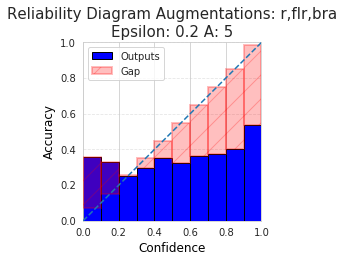

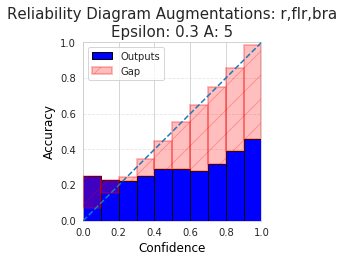

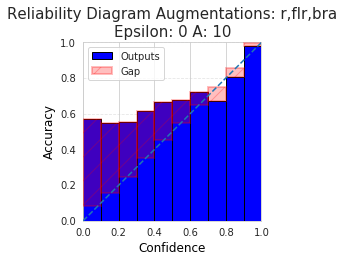

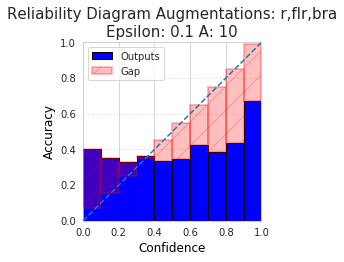

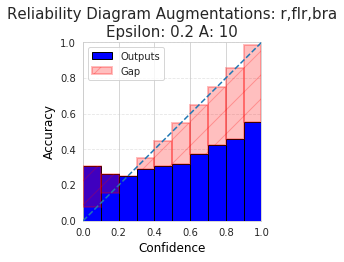

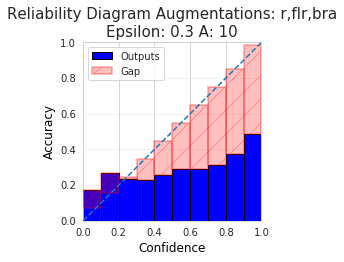

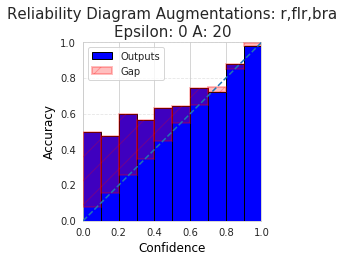

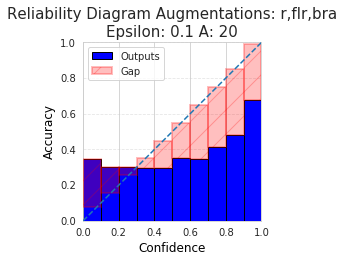

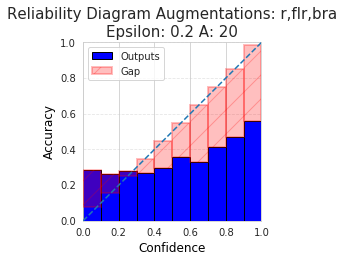

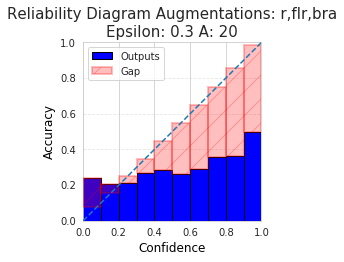

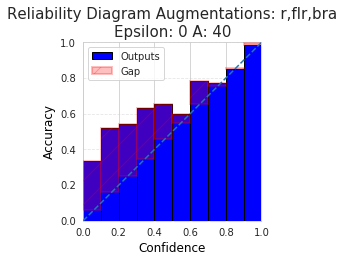

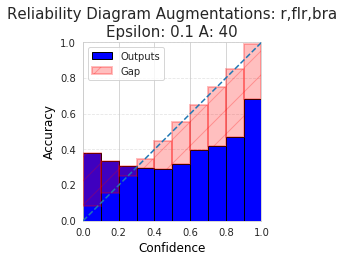

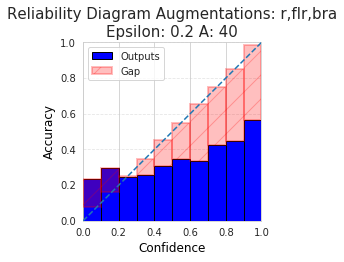

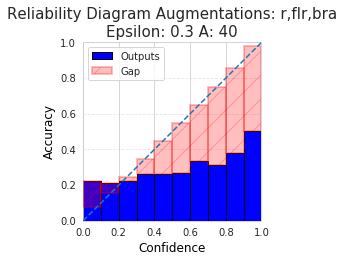

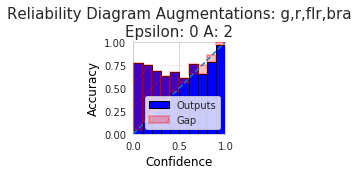

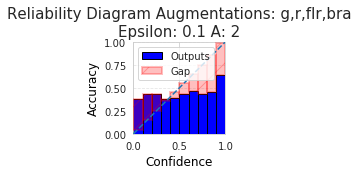

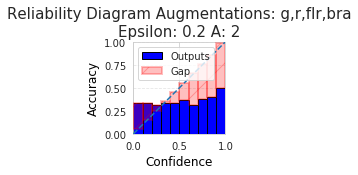

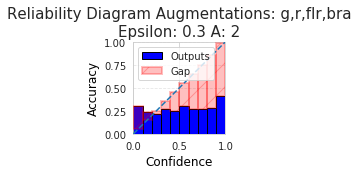

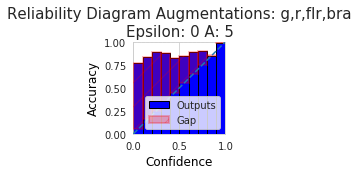

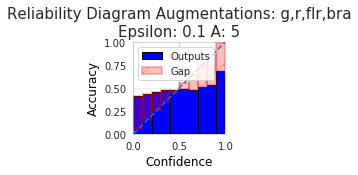

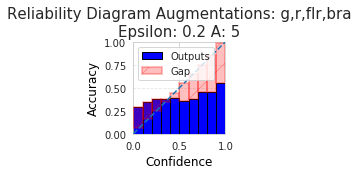

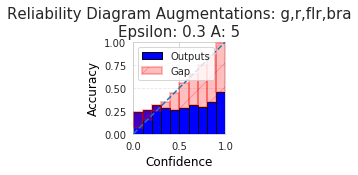

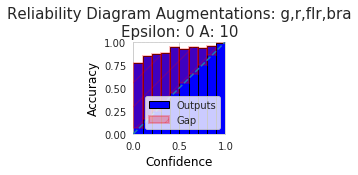

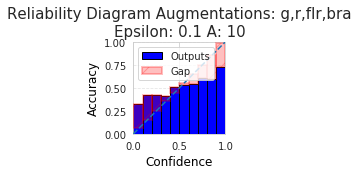

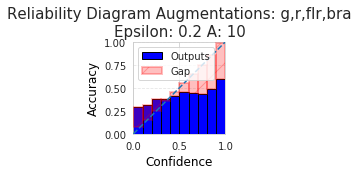

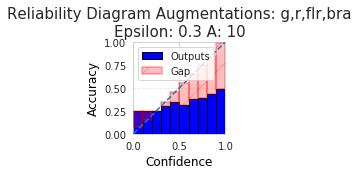

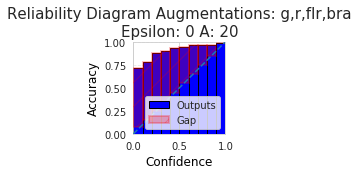

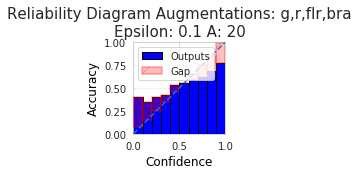

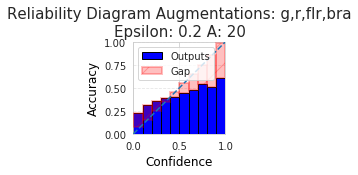

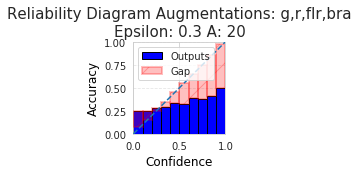

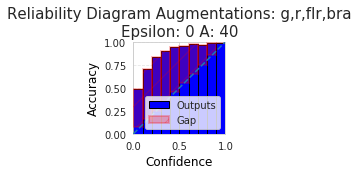

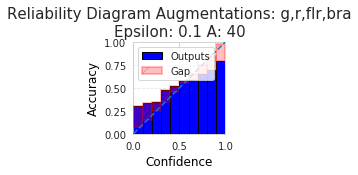

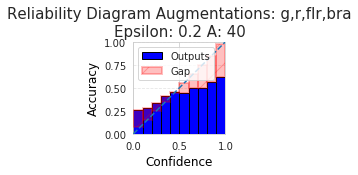

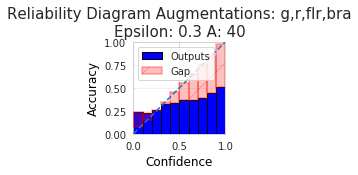

In [14]:
augmentations_list = ["none","g", "r", "flr", "bra", "r,flr,bra", "g,r,flr,bra"]
n_augs = [2,5,10,20,40]
epsilons = [0,0.1,0.2, 0.3]

results = []

for aug in augmentations_list:
    for n in n_augs:
        for epsilon in epsilons:
            final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
            #some statistics if necessary
            pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
            #get ece and bins
            ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
            #plot it
            if aug == "none":
                title = "Reliability Diagram No Augmentations\nEpsilon: {}".format(epsilon)
            else:
                title = "Reliability Diagram Augmentations: {}\nEpsilon: {} A: {}".format(aug, epsilon,n)
            fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
            results.append({"augments":aug,"n":n,"epsilon":epsilon,"accuracy":final_acc,"ece":ece,"figure":fig})
            plt.figure(fig.number)
            plt.savefig("plots/reliability_diagram_n{}_aug-{}_epsilon{}.png".format(n,aug.replace(",","-"),epsilon))

In [16]:
import pandas as pd
import pickle
df = pd.DataFrame(results)
df.to_pickle("results_20200409.pandaspickle")
df.head(140)

augments   n  epsilon  accuracy             ece           figure
0           none   2      0.0  0.945067  tensor(0.0386)  Figure(324x288)
1           none   2      0.1  0.536533  tensor(0.4097)  Figure(324x288)
2           none   2      0.2  0.419467  tensor(0.5047)  Figure(324x288)
3           none   2      0.3  0.322267  tensor(0.5785)  Figure(324x288)
4           none   5      0.0  0.945067  tensor(0.0386)  Figure(324x288)
..           ...  ..      ...       ...             ...              ...
135  g,r,flr,bra  20      0.3  0.352800  tensor(0.2321)  Figure(324x288)
136  g,r,flr,bra  40      0.0  0.943600  tensor(0.2499)  Figure(324x288)
137  g,r,flr,bra  40      0.1  0.576800  tensor(0.1268)  Figure(324x288)
138  g,r,flr,bra  40      0.2  0.457600  tensor(0.1740)  Figure(324x288)
139  g,r,flr,bra  40      0.3  0.355733  tensor(0.2100)  Figure(324x288)

[140 rows x 6 columns]

In [17]:
df.to_csv("results_20200409.csv")

In [5]:
n = 5
epsilon = 0
aug = "g,flr,r"
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=0,
                                                                             augmentations = "none")

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 7088 / 7500 = 0.9450666666666667


Expected Calibration Error: 0.03864627331495285


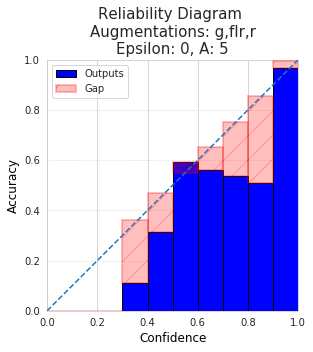

In [7]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, epsilon,n)
figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)

plt.figure(figure.number)


print("Expected Calibration Error: {}".format(ece))


In [22]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, mode="mode", epsilon=0, augmentations = "r,flr,bra", n = 21, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 2348 / 2500 = 0.9392


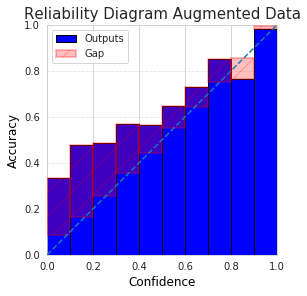

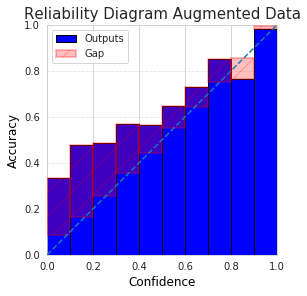

In [23]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Data")

In [17]:
final_acc_adv, adv_examples_adv, pred_log_probs_adv, target_labels_adv = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "r,flr,bra", n = 21, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0.3	Test Accuracy = 923 / 2500 = 0.3692


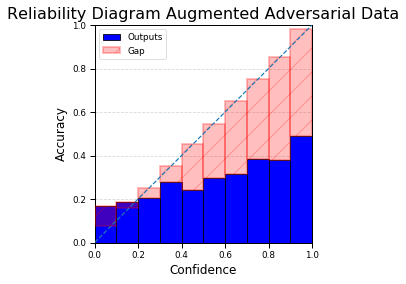

In [18]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs_adv)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels_adv, pred_log_probs_adv)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Adversarial Data")


In [19]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "r,flr,bra", n = 5, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 2364 / 2500 = 0.9456


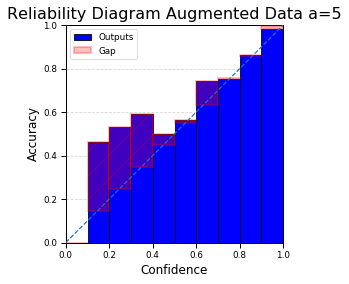

In [20]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Data a=5")

In [21]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "r,flr,bra", n = 50, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 2376 / 2500 = 0.9504


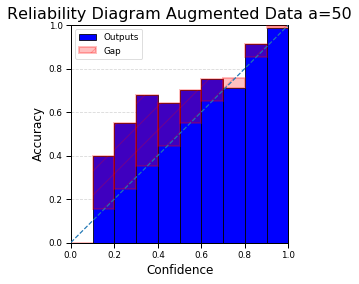

In [22]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Data a=50")

In [25]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "r,flr,bra", n = 2, v = 1)

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 2360 / 2500 = 0.944


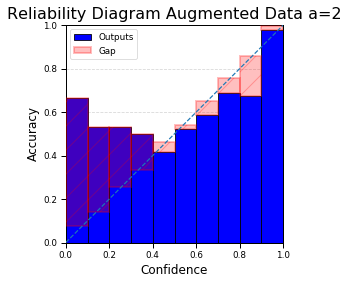

In [26]:
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
utility.reliability_diagram_plot(bin_accs, bin_confs, title="Reliability Diagram Augmented Data a=2")

# FID

In [5]:
n_batches = 2
inputs_arr = []
iter_dataloader = iter(trainloader)
for _ in range(n_batches):
    cur_inputs, c =  next(iter_dataloader)
    inputs_arr.append(cur_inputs)
    
inputs = torch.cat(inputs_arr, dim = 0)
inputs.shape

torch.Size([200, 3, 32, 32])

In [6]:
model_features, p = utility.get_features(model)

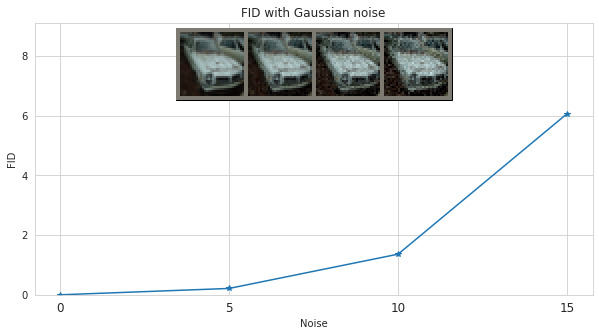

In [7]:
params = [0,5,10,15]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="g", noise_level=params, bottleneck=True)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with Gaussian noise")

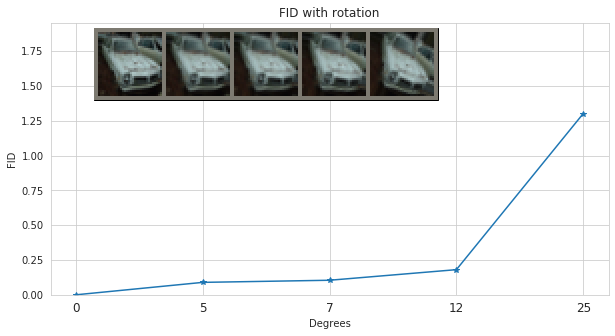

In [8]:
params = [0,5,7,12,25]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="r", noise_level=params, bottleneck = True)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with rotation", xlabel="Degrees")

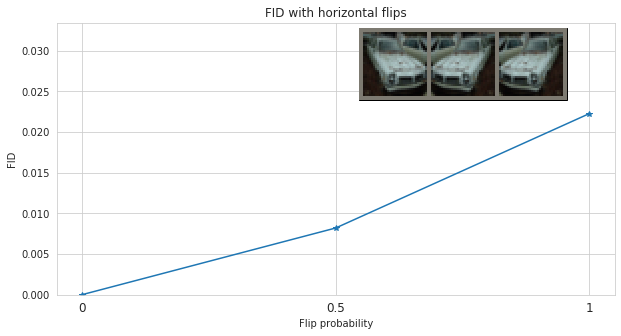

In [9]:
params = [0,0.5,1]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="flr", noise_level=params, bottleneck = True)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with horizontal flips", xlabel="Flip probability")

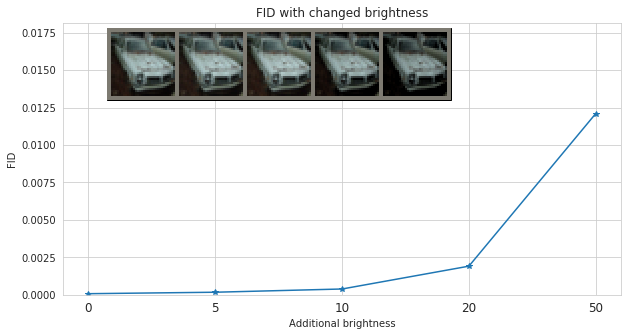

In [12]:
params = [0,5,10,20,50]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="bra", noise_level=params, bottleneck = True)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with changed brightness", xlabel="Additional brightness")